<a href="https://colab.research.google.com/github/s183796/AIStudentProjects/blob/christine/Unet_2d_total_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn.functional import softmax
import PIL.Image
import os
import torchvision
import cv2

from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
import glob
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
pip install albumentations

In [19]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [20]:
class UNet(nn.Module): #from https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
    def __init__(self, n_class):
        super().__init__()

        # input: 1x128x128
        self.e11 = nn.Conv2d(1, 64, kernel_size=3,padding=1)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #64x64x64

        self.e21 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #32x32x128

        self.e31 = nn.Conv2d(128, 256, kernel_size=3,padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3,padding=1)

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #16x16x256

        self.e41 = nn.Conv2d(256, 512, kernel_size=3,padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3,padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #8x8x512

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3,padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3,padding=1)

        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #16x16x1024
        self.d11 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
        self.d12 = nn.Conv2d(512,512,kernel_size=3,padding=1)

        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.d21 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.d22 = nn.Conv2d(256,256,kernel_size=3,padding=1)

        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.d31 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.d32 = nn.Conv2d(128,128,kernel_size=3,padding=1)

        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.d41 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.d42 = nn.Conv2d(64,64,kernel_size=3,padding=1)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)


        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))


        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Up-convolutions
        xup1 = self.upconv1(xe52)
        #xcat=xup1
        xcat = torch.cat([xup1, xe42], dim=1)

        xup21 = F.relu(self.d11(xcat))
        xup22 = F.relu(self.d12(xup21))

        xup2 = self.upconv2(xup22)
        #xcat2=xup2
        #xcat2 = torch.cat([xup2, xe32[:,:,:-1,:-1]], dim=1)
        xcat2 = torch.cat([xup2, xe32], dim=1)


        xup31 = F.relu(self.d21(xcat2))
        xup32 = F.relu(self.d22(xup31))
        xup3 = self.upconv3(xup32)
        #xcat3=xup3
        xcat3 = torch.cat([xup3, xe22], dim=1)

        xup41 = F.relu(self.d31(xcat3))
        xup42 = F.relu(self.d32(xup41))

        xup4 = self.upconv4(xup42)
        #xcat4 = torch.cat([xup4, xe12[:,:,2:-3,2:-3]], dim=1)
        xcat4 = torch.cat([xup4, xe12], dim=1)
        #xcat4=xup4
        xup51 = F.relu(self.d41(xcat4))
        xup52 = F.relu(self.d42(xup51))

        out = self.outconv(xup52)

        output = softmax(out,dim=1)

        return output

In [21]:
#Setting up hyper parameters, from exercise week 6


loss_fn =  nn.CrossEntropyLoss()         # <-- Your code here.

import random


In [22]:
class Trainingdataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'data/')
        self.label_folder = os.path.join(root_dir, 'labels/')
        self.transform = transform

        self.image_filenames = sorted([f for f in os.listdir(self.image_folder) if f.endswith('.tiff')][:100])
        self.label_filenames = sorted([f for f in os.listdir(self.label_folder) if f.endswith('.tif')][:100])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
      img_name = os.path.join(self.image_folder, self.image_filenames[idx])

      number1=img_name[-8:-5] #make sure the label fits with the image
      label_name=os.path.join(self.label_folder,'slice__'+str(number1)+'.tif')

      image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)

      image=np.array(image)
      label=np.array(label)

      if self.transform is not None:
        augmentations=self.transform(image=image,mask=label)

      image=augmentations["image"]
      label=augmentations["mask"]

      return image, label

In [23]:
class Testdataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'data/')
        self.label_folder = os.path.join(root_dir, 'labels/')
        self.transform = transform

        self.image_filenames = sorted([f for f in os.listdir(self.image_folder) if f.endswith('.tiff')][-100:])
        self.label_filenames = sorted([f for f in os.listdir(self.label_folder) if f.endswith('.tif')][-100:])


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
      img_name = os.path.join(self.image_folder, self.image_filenames[idx])

      number1=img_name[-8:-5] #make sure the label fits with the image
      label_name=os.path.join(self.label_folder,'slice__'+str(number1)+'.tif')

      image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)

      image=np.array(image)
      label=np.array(label)

      if self.transform is not None:
        augmentations=self.transform(image=image,mask=label)

      image=augmentations["image"]
      label=augmentations["mask"]

      return image, label

In [24]:

transform = A.Compose(
    [
     A.HorizontalFlip(p=0.5),
     A.RandomCrop(width=128, height=128),
     A.VerticalFlip(p=0.1),
     A.RandomBrightnessContrast(p=0.2),  # Adjust brightness/contrast
     A.GaussNoise(p=0.2),  # Add Gaussian noise
     A.Resize(64, 64, p=0.2),  # Downsample to 64x64
     A.Resize(128, 128),  # Upsample back to 128x128
     A.Normalize(
        mean=[0.5],
        std=[0.5],
        max_pixel_value=255.0,
     ),
     ToTensorV2(),
    ]
)

#The transformations fro test only consist of normalization and to tensor transform
transform_test = A.Compose(
    [
     A.Normalize(
        mean=[0.5],
        std=[0.5],
        max_pixel_value=255.0,
     ),
     ToTensorV2(),
    ]
)



In [25]:
SOC_dataset = Trainingdataset(root_dir='drive/My Drive//AI data/', transform = transform)


In [26]:
SOC_dataset_label=Testdataset(root_dir='drive/My Drive//AI data/', transform = transform_test)

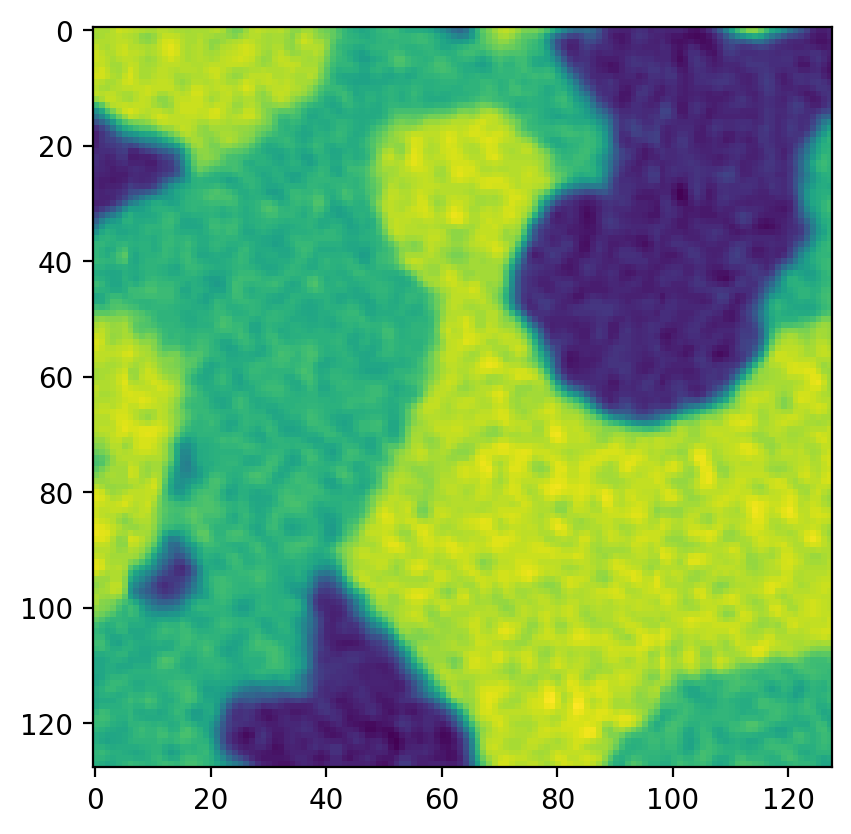

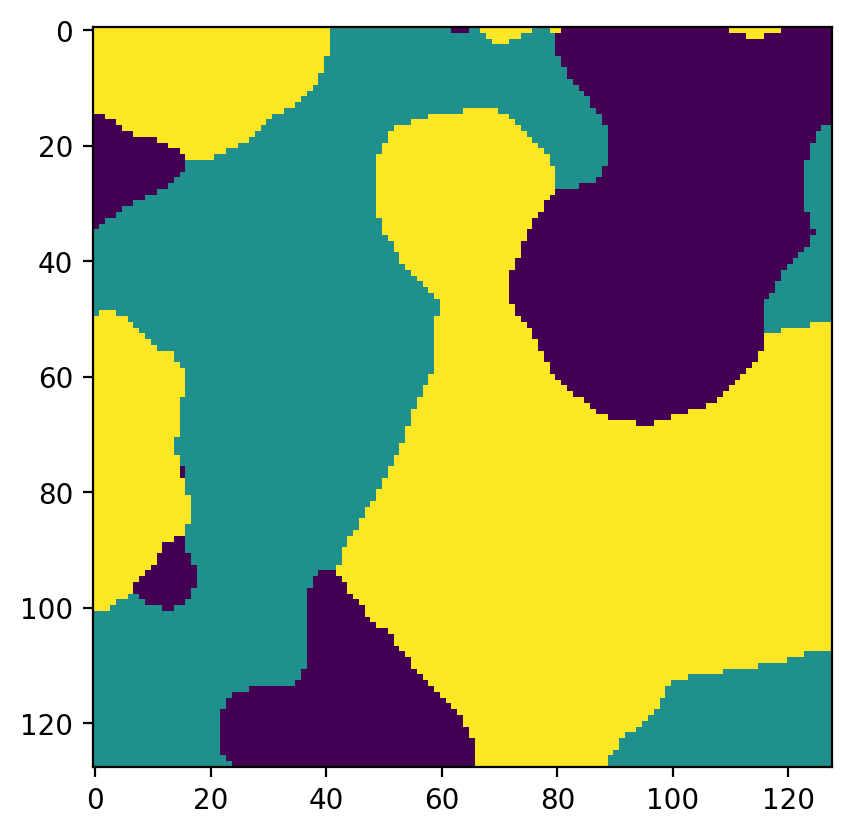

In [27]:
#Example of output to check image and label match

image,label=SOC_dataset[33]

plt.figure(dpi=200)
plt.imshow(image[0,:,:])

plt.figure(dpi=200)
plt.imshow(label)

In [28]:
pip install torchmetrics

In [29]:
from torchmetrics.classification import JaccardIndex
from torchmetrics.functional.classification import dice
from torchmetrics.classification import MulticlassAccuracy

In [30]:
test_size=0.3
batch_size = 16

training_idx, test_idx = train_test_split(
    range(len(SOC_dataset)),
    test_size=test_size,
    random_state=42
)

train_loader = DataLoader(Subset(SOC_dataset, training_idx), batch_size=batch_size, shuffle=True,drop_last=False)
test_loader = DataLoader(Subset(SOC_dataset, test_idx), batch_size=batch_size,drop_last=True)
val_loader = DataLoader(SOC_dataset_label, batch_size=batch_size,drop_last=True)

In [31]:
#Code is inspired by exercise 4.2-EXE-CNN-CIFAR-10.ipynb
net=UNet(n_class=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

optimizer = optim.Adam(net.parameters(), lr=0.0001) #choosing the Adam optimizzer

#Defining the different accuracy metrics
jaccard=JaccardIndex(task="multiclass", num_classes=3).to(device)
accuracy=MulticlassAccuracy(num_classes=3).to(device)
batch_size = 16 #batchsize
num_epochs = 50
validation_every_steps = np.ceil(len(train_loader.dataset)/batch_size) #How often the validation should be

step = 0
net.train()

train_accuracies_jaccard = []
train_accuracies_dice = []
train_accuracies_pixel = []
valid_accuracies_jaccard = []
valid_accuracies_dice = []
valid_accuracies_pixel = []

for epoch in range(num_epochs):
    train_accuracies_batches_jaccard = []
    train_accuracies_batches_dice = []
    train_accuracies_batches_pixel = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # Forward pass.
        output = net(inputs)

        #Divide targets into classes: [0,1,2]
        un_target=targets.unique()
        targets[targets==un_target[0]]=0
        targets[targets==un_target[1]]=1
        targets[targets==un_target[2]]=2

        targets = targets.to(torch.int64)

        #compute loss function
        loss = loss_fn(output, targets)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        step += 1

        # Compute accuracy.
        predictions = torch.argmax(output,dim=1) #Prediction with max of softmax output
        train_accuracies_batches_dice.append(dice(predictions,targets).cpu())
        train_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
        train_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies_jaccard.append(np.mean(train_accuracies_batches_jaccard))
            train_accuracies_dice.append(np.mean(train_accuracies_batches_dice))
            train_accuracies_pixel.append(np.mean(train_accuracies_batches_pixel))

            train_accuracies_batches_jaccard = []
            train_accuracies_batches_dice = []
            train_accuracies_batches_pixel = []

            # Compute accuracies on validation set.
            valid_accuracies_batches_jaccard = []
            valid_accuracies_batches_dice = []
            valid_accuracies_batches_pixel = []
            with torch.no_grad():
                net.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = net(inputs)

                    un_target=targets.unique()
                    # Compute loss.
                    targets[targets==un_target[0]]=0
                    targets[targets==un_target[1]]=1
                    targets[targets==un_target[2]]=2

                    targets = targets.to(torch.int64)

                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]
                    valid_accuracies_batches_dice.append(dice(predictions,targets).cpu())
                    valid_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
                    valid_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

                net.train()

            # Append average validation accuracy to list.
            valid_accuracies_jaccard.append(np.sum(valid_accuracies_batches_jaccard) / len(test_loader))
            valid_accuracies_dice.append(np.sum(valid_accuracies_batches_dice) / len(test_loader))
            valid_accuracies_pixel.append(np.sum(valid_accuracies_batches_pixel) / len(test_loader))

            print(f"Step {step:<5}   training accuracy with jaccard: {train_accuracies_jaccard[-1]}")
            print(f"             training accuracy with dice: {train_accuracies_dice[-1]}")
            print(f"             training accuracy with pixel by pixel: {train_accuracies_pixel[-1]}")
            print(f"             test accuracy with jaccard: {valid_accuracies_jaccard[-1]}")
            print(f"             test accuracy with dice: {valid_accuracies_dice[-1]}")
            print(f"             test accuracy with pixel by pixel: {valid_accuracies_pixel[-1]}")


print("Finished training.")

Step 5       training accuracy with jaccard: 0.1097823828458786
             training accuracy with dice: 0.3015401065349579
             training accuracy with pixel by pixel: 0.3368796408176422
             test accuracy with jaccard: 0.19864070415496826
             test accuracy with dice: 0.3799705505371094
             test accuracy with pixel by pixel: 0.3923020660877228
Step 10      training accuracy with jaccard: 0.31477832794189453
             training accuracy with dice: 0.5346056222915649
             training accuracy with pixel by pixel: 0.5100517272949219
             test accuracy with jaccard: 0.46131759881973267
             test accuracy with dice: 0.6864204406738281
             test accuracy with pixel by pixel: 0.6186341047286987
Step 15      training accuracy with jaccard: 0.4096253514289856
             training accuracy with dice: 0.6161936521530151
             training accuracy with pixel by pixel: 0.5884076952934265
             test accuracy with jaccard: 

In [32]:
val_acc_dice=[]
val_acc_jaccard=[]
val_acc_pixel=[]

for inputs, targets in val_loader:
  inputs_val, targets = inputs.to(device), targets.to(device)

un_target=targets.unique()
# Compute loss.
targets[targets==un_target[0]]=0
targets[targets==un_target[1]]=1
targets[targets==un_target[2]]=2

targets_val=targets

In [33]:
B, C, W, H = inputs_val.size(0), inputs_val.size(1), inputs_val.size(2), inputs_val.size(3)

kernel_size = 128
stride = 64

images_split_1 = inputs_val.unfold(3, kernel_size, stride).unfold(2, kernel_size, stride).permute(0,1,2,3,5,4)
targets_split=targets_val.unfold(2, kernel_size, stride).unfold(1, kernel_size, stride).permute(0,1,2,4,3)


In [34]:
preds=torch.empty(images_split_1.size(0),images_split_1.size(2),images_split_1.size(3),images_split_1.size(-1), images_split_1.size(-1))
tar=targets_split

for i in range(images_split_1.size(2)):
  for j in range(images_split_1.size(3)):
    output_val = net(images_split_1[:,:,i,j,:,:])
    predicted_val = output_val.max(1)[1]

    val_acc_dice.append(dice(predicted_val,tar[:,i,j,:,:]))
    val_acc_jaccard.append(jaccard(predicted_val,tar[:,i,j,:,:]))
    val_acc_pixel.append(accuracy(predicted_val,tar[:,i,j,:,:]))

    '''
    output=output_val
    targets=targets_split_1[0,0,i,:,:]
    predicted=predicted_val
    inputs=inputs_val

    fig,axs = plt.subplots(2,2,figsize=(15,15))
    im1=axs[0,0].imshow(output.detach().cpu().numpy()[0,0,:,:])
    axs[0,0].set_title('Label 1, probability')
    cbar1=plt.colorbar(im1, ax=axs[0,0])
    im1.set_clim(0,1)
    im2=axs[1,0].imshow(output.detach().cpu().numpy()[0,1,:,:])
    axs[1,0].set_title('Label 2, probability')
    plt.colorbar(im2, ax=axs[1,0])
    im2.set_clim(0,1)
    im3=axs[0,1].imshow(output.detach().cpu().numpy()[0,2,:,:])
    axs[0,1].set_title('Label 3,probabiliy')
    plt.colorbar(im3, ax=axs[0,1])
    im3.set_clim(0,1)
    im4=axs[1,1].imshow(targets.cpu())
    axs[1,1].set_title('Target labels')
    plt.colorbar(im4, ax=axs[1,1],ticks=[0,1,2])
    fig.suptitle('Probability distribution for each class', fontsize=16)

    plt.show()

    fig,axs=plt.subplots(2,2,figsize=(15,15))
    im1=axs[1,0].imshow(predicted[0,:,:].cpu())
    axs[1,0].set_title('Predicted labels')
    plt.colorbar(im1, ax=axs[1, 0],ticks=[0,1,2])
    im2=axs[1,1].imshow(targets.cpu())
    axs[1,1].set_title('Target labels')
    plt.colorbar(im2, ax=axs[1,1],ticks=[0,1,2])
    im3=axs[0,0].imshow(inputs[0,0,:,:].cpu())
    axs[0,0].set_title('Original image')
    plt.colorbar(im3, ax=axs[0,0])
    im4=axs[0,1].imshow(targets.cpu()-predicted[0,:,:].cpu())
    axs[0,1].set_title('Difference between mask and prediction')
    plt.colorbar(im4, ax=axs[0,1],ticks=[0,1,2])

    fig.suptitle('Comparison of target and predicted mask', fontsize=16)
    plt.show()
    '''

    preds[:,i,j,:,:]=predicted_val

torch.Size([16, 1, 501, 501])
torch.Size([16, 16384, 36])
torch.Size([16, 1, 501, 501])


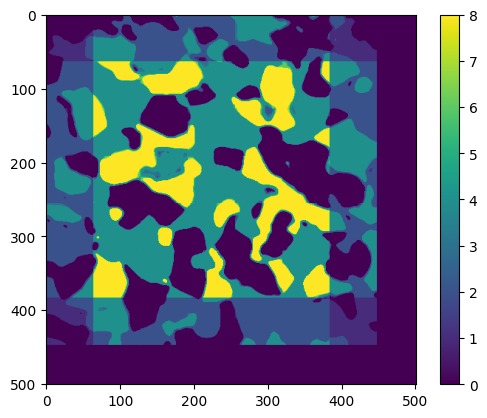

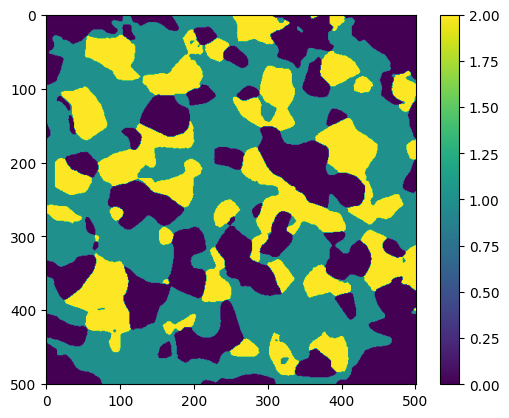

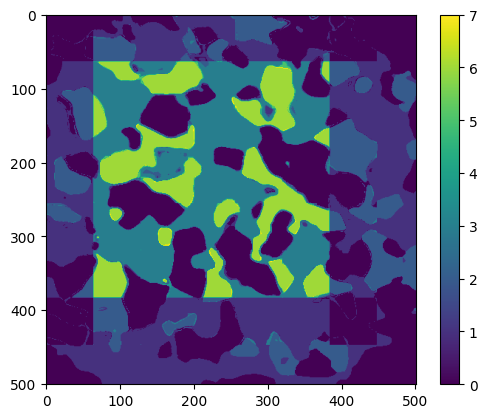

In [35]:
patches = preds.contiguous().view(B, -1, kernel_size*kernel_size)

patches = patches.permute(0,2,1)

patches = patches.contiguous().view(B, C*kernel_size*kernel_size, -1)

output = torch.nn.functional.fold(
    patches, output_size=(H, W), kernel_size=kernel_size, stride=stride)
print(output.shape) # [B, C, H, W]

mask=torch.ones(patches.size())
print(mask.size())

mask_output = torch.nn.functional.fold(
    mask, output_size=(H, W), kernel_size=kernel_size, stride=stride)
print(mask_output.shape) # [B, C, H, W]

# Normalize and recale to [0,2]
#output = 2 * (output - output.min()) / (output.max() - min_value)


plt.figure()
plt.imshow(output[0,0,:,:].detach().cpu())
plt.colorbar()

plt.figure()
plt.imshow(targets_val[0,:,:].detach().cpu())
plt.colorbar()

plt.figure()
plt.imshow(np.abs(targets_val[0,:,:].detach().cpu().numpy()-output[0,0,:,:].detach().cpu().numpy()))
plt.colorbar()

In [1]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
axs[0].plot(train_accuracies_dice,color='red',label='dice')
axs[0].plot(train_accuracies_jaccard,color='blue',label='jaccard')
axs[0].plot(train_accuracies_pixel,color='green',label='pixel-wise')
axs[0].legend()
axs[0].set_title('Training accuracies')
axs[0].set_xlabel('Epoch number')
axs[0].set_ylabel('Accuracy)')

axs[1].plot(valid_accuracies_dice,color='red',label='dice')
axs[1].plot(valid_accuracies_jaccard,color='blue',label='jaccard')
axs[1].plot(valid_accuracies_pixel,color='green',label='pixel-wise')
axs[1].legend()
axs[1].set_title('Validation accuracies')
axs[1].set_xlabel('Epoch number')
axs[1].set_ylabel('Accuracy)')

fig,axs=plt.subplots(1,3,figsize=(15,5))
axs[0].plot(train_accuracies_dice,color='red',label='Training accuracy')
axs[0].plot(valid_accuracies_dice,color='blue',label='Validation accuracy')
axs[0].set_title('Dice coefficient accuracies')
axs[0].legend()

axs[1].plot(train_accuracies_jaccard,color='red',label='Training accuracy')
axs[1].plot(valid_accuracies_jaccard,color='blue',label='Validation accuracy')
axs[1].set_title('Jaccard coefficient accuracies')
axs[1].legend()

axs[2].plot(train_accuracies_pixel,color='red',label='Training accuracy')
axs[2].plot(valid_accuracies_pixel,color='blue',label='Validation accuracy')
axs[2].set_title('Pixelwise coefficient accuracies')
axs[2].legend()

NameError: ignored

In [ ]:
from torchvision.utils import make_grid
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)

outputs = net(inputs)
_, predicted = torch.max(outputs.data, 1)

un_target=targets.unique()
# Compute loss.
targets[targets==un_target[0]]=0
targets[targets==un_target[1]]=1
targets[targets==un_target[2]]=2

targets = targets.to(torch.int64)

fig,axs = plt.subplots(1,3,figsize=(15,15))

axs[0].imshow(output.detach().cpu().numpy()[0,0,:,:])
axs[0].set_title('Label 1, probability')
axs[1].imshow(output.detach().cpu().numpy()[0,1,:,:])
axs[1].set_title('Label 2, probability')
axs[2].imshow(output.detach().cpu().numpy()[0,2,:,:])
axs[2].set_title('Label 3,probabiliy')
fig.suptitle('Probability distribution for each class', fontsize=16)
plt.show()


In [ ]:
fig,axs=plt.subplots(2,2,figsize=(15,15))
im1=axs[1,0].imshow(predicted[0,:,:].cpu())
axs[1,0].set_title('Predicted labels')
plt.colorbar(im1, ax=axs[1, 0])
targets = targets.to(torch.int64) [0,:,:]
im2=axs[0,1].imshow(targets.cpu())
axs[0,1].set_title('Target labels')
plt.colorbar(im2, ax=axs[0,1])
im3=axs[0,0].imshow(inputs[0,0,:,:].cpu())
axs[0,0].set_title('Original image')
plt.colorbar(im3, ax=axs[0,0])
im4=axs[1,1].imshow(targets.cpu()-predicted[0,:,:].cpu())
axs[1,1].set_title('Difference between mask and prediction')
plt.colorbar(im4, ax=axs[1,1])

fig.suptitle('Comparison of target and predicted mask', fontsize=16)
plt.show()